In [1]:
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

## RNN - In built

Random seed set as 42
Device used: cpu
torch.Size([100, 1, 28, 28]) torch.Size([100])
Epoch: 1/2, Step: 100/600, Loss: 0.9081
Epoch: 1/2, Step: 200/600, Loss: 0.3941
Epoch: 1/2, Step: 300/600, Loss: 0.4813
Epoch: 1/2, Step: 400/600, Loss: 0.3429
Epoch: 1/2, Step: 500/600, Loss: 0.3256
Epoch: 1/2, Step: 600/600, Loss: 0.3805
Epoch: 2/2, Step: 100/600, Loss: 0.5672
Epoch: 2/2, Step: 200/600, Loss: 0.2217
Epoch: 2/2, Step: 300/600, Loss: 0.2479
Epoch: 2/2, Step: 400/600, Loss: 0.2086
Epoch: 2/2, Step: 500/600, Loss: 0.2300
Epoch: 2/2, Step: 600/600, Loss: 0.2075
Accuracy of the network on the 10000 test images: 94.89 %


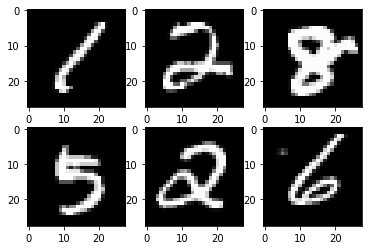

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

set_seed(42)

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# hyperparameters
# input_size = 784  # 28 x 28
num_classes = 10
n_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2 # Stacking 2 RNNs

# load data
train_dataset = torchvision.datasets.MNIST(root="../data",
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=False)
test_dataset = torchvision.datasets.MNIST(root="../data",
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=False)

# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# plot samples
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(samples[i][0], cmap="gray")  # [0] for first channel


# define model
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes=10):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.rnn(x, h0) # size -> (batch_size, seq_length, hidden_size), (N, 28, 128)
        # What we want is (N, 128)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch: {epoch + 1}/{n_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}"
            )

# evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # returns value, index and we are interested in "index"
        _, predictions = torch.max(outputs, axis=1)
        n_samples = n_samples + labels.size(0)

        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * (n_correct / n_samples)
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

## LSTM - Inbuilt

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

set_seed(42)

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# hyperparameters
# input_size = 784  # 28 x 28
num_classes = 10
n_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2 # Stacking 2 RNNs

# load data
train_dataset = torchvision.datasets.MNIST(root="../data",
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=False)
test_dataset = torchvision.datasets.MNIST(root="../data",
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=False)

# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# define model
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes=10):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0)) # size -> (batch_size, seq_length, hidden_size), (N, 28, 128)
        # What we want is (N, 128)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch: {epoch + 1}/{n_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}"
            )

# evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # returns value, index and we are interested in "index"
        _, predictions = torch.max(outputs, 1)
        n_samples = n_samples + labels.size(0)

        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * (n_correct / n_samples)
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Random seed set as 42
Device used: cpu
Epoch: 1/2, Step: 100/600, Loss: 0.6078
Epoch: 1/2, Step: 200/600, Loss: 0.4355
Epoch: 1/2, Step: 300/600, Loss: 0.2759
Epoch: 1/2, Step: 400/600, Loss: 0.2150
Epoch: 1/2, Step: 500/600, Loss: 0.2349
Epoch: 1/2, Step: 600/600, Loss: 0.1109
Epoch: 2/2, Step: 100/600, Loss: 0.1330
Epoch: 2/2, Step: 200/600, Loss: 0.0426
Epoch: 2/2, Step: 300/600, Loss: 0.0903
Epoch: 2/2, Step: 400/600, Loss: 0.1464
Epoch: 2/2, Step: 500/600, Loss: 0.1373
Epoch: 2/2, Step: 600/600, Loss: 0.1599
Accuracy of the network on the 10000 test images: 97.18 %


## GRU - Inbuilt

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

set_seed(42)

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# hyperparameters
# input_size = 784  # 28 x 28
num_classes = 10
n_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2 # Stacking 2 RNNs

# load data
train_dataset = torchvision.datasets.MNIST(root="../data",
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=False)
test_dataset = torchvision.datasets.MNIST(root="../data",
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=False)

# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)



# define model
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes=10):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size)
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.gru(x, h0) # size -> (batch_size, seq_length, hidden_size), (N, 28, 128)
        # What we want is (N, 128)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


model = GRU(input_size, hidden_size, num_layers, num_classes).to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch: {epoch + 1}/{n_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}"
            )

# evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # reshape images from 100 x 1 x 28 x 28 --> 100 x 28 x 28
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # returns value, index and we are interested in "index"
        _, predictions = torch.max(outputs, 1)
        n_samples = n_samples + labels.size(0)

        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * (n_correct / n_samples)
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Random seed set as 42
Device used: cpu
Epoch: 1/2, Step: 100/600, Loss: 0.8453
Epoch: 1/2, Step: 200/600, Loss: 0.3421
Epoch: 1/2, Step: 300/600, Loss: 0.2726
Epoch: 1/2, Step: 400/600, Loss: 0.1081
Epoch: 1/2, Step: 500/600, Loss: 0.1390
Epoch: 1/2, Step: 600/600, Loss: 0.1607
Epoch: 2/2, Step: 100/600, Loss: 0.1424
Epoch: 2/2, Step: 200/600, Loss: 0.1008
Epoch: 2/2, Step: 300/600, Loss: 0.1171
Epoch: 2/2, Step: 400/600, Loss: 0.1928
Epoch: 2/2, Step: 500/600, Loss: 0.0602
Epoch: 2/2, Step: 600/600, Loss: 0.1883
Accuracy of the network on the 10000 test images: 97.44 %
